# Multiple kernels

Extend this to 2D (time + space)
Add curriculum or importance sampling next

In [20]:
from typing import Optional, Dict, Tuple, Union, Any

import torch
from torch.utils.data import Dataset, DataLoader
import gpytorch
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.kernels import Kernel, RBFKernel, MaternKernel, PeriodicKernel
from gpytorch.priors import SmoothedBoxPrior
import matplotlib.pyplot as plt


In [21]:
class MultiTimeSeriesDataset(Dataset):
    def __init__(
        self,
        num_series: int = 5,
        num_points: int = 450,
        weights: Optional[Dict[str, float]] = None
    ) -> None:
        """
        Synthetic multi-time-series dataset with decomposed components.

        Args:
            num_series (int): Number of independent time series to generate.
            num_points (int): Number of time steps per series.
            weights (dict, optional): Relative weights for each component. Example:
                {"long": 1.0, "seasonal": 0.5, "short": 0.2}
        """
        self.num_series = num_series
        self.num_points = num_points

        # Time vector [T, 1]
        self.x = torch.linspace(0, 1, num_points).unsqueeze(-1)

        # Default weights if none provided
        self.weights = weights or {
            "long": 2.0,
            "seasonal": 0.8,
            "short": 0.5,
        }

        # Store each time series and its components
        y_list = []
        self.true_components = {
            "long_term": [],
            "seasonal": [],
            "short_term": []
        }

        for _ in range(num_series):
            # Generate long-term component (linear trend)
            slope = 1.0 + 0.3 * torch.randn(1)
            intercept = 0.1 * torch.randn(1)
            long_term = self.weights["long"] * (slope * self.x + intercept)

            # Generate seasonal component (sine wave with noise)
            freq = 4.0 + 0.2 * torch.randn(1)
            phase = 2 * torch.pi * torch.rand(1)
            seasonal = self.weights["seasonal"] * torch.sin(freq * 2 * torch.pi * self.x + phase)

            # Generate short-term noise
            short_term = self.weights["short"] * torch.randn_like(self.x)

            # Combine to produce the observed series
            y_series = long_term + seasonal + short_term

            # Append components
            self.true_components["long_term"].append(long_term)
            self.true_components["seasonal"].append(seasonal)
            self.true_components["short_term"].append(short_term)

            y_list.append(y_series)

        # Stack to tensors [N, T, 1]
        self.y = torch.stack(y_list)
        for key in self.true_components:
            self.true_components[key] = torch.stack(self.true_components[key])

    def __len__(self) -> int:
        """Returns the number of series."""
        return self.num_series

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Retrieve time series and its components.

        Args:
            idx (int): Index of the time series.

        Returns:
            Tuple[Tensor, Tensor, Tensor, Tensor, Tensor]: (x, y, long_term, seasonal, short_term), all of shape [T]
        """
        return (
            self.x.squeeze(),
            self.y[idx].squeeze(),
            self.true_components["long_term"][idx].squeeze(),
            self.true_components["seasonal"][idx].squeeze(),
            self.true_components["short_term"][idx].squeeze(),
        )

    def plot_dataset(self, num_series_to_plot: int = 3, figsize: Tuple[int, int] = (12, 4)) -> None:
        """
        Visualize a few generated time series and their component signals.

        Args:
            num_series_to_plot (int): Number of series to visualize.
            figsize (Tuple[int, int]): Size of each plot figure.
        """
        num_series_to_plot = min(num_series_to_plot, self.num_series)
        x_plot = self.x.squeeze().numpy()

        for i in range(num_series_to_plot):
            y = self.y[i].squeeze().numpy()
            f_long = self.true_components["long_term"][i].squeeze().numpy()
            f_seasonal = self.true_components["seasonal"][i].squeeze().numpy()
            f_short = self.true_components["short_term"][i].squeeze().numpy()

            plt.figure(figsize=figsize)
            plt.plot(x_plot, y, label="Total (f)", color="black", linewidth=1.5)
            plt.plot(x_plot, f_long, label="Long-term", linestyle="--")
            plt.plot(x_plot, f_seasonal, label="Seasonal", linestyle=":")
            plt.plot(x_plot, f_short, label="Short-term", linestyle="-.", alpha=0.7)
            plt.title(f"Time Series {i}")
            plt.xlabel("Time")
            plt.ylabel("Value")
            plt.legend()
            plt.tight_layout()
            plt.show()

In [22]:
def check_dataset_format(
    x: Union[torch.Tensor, list],
    y: Union[torch.Tensor, list],
    name: str = "dataset"
) -> None:
    """
    Validates the shape, type, and value range of input tensors `x` and `y`
    commonly used for training Gaussian Process models.

    Args:
        x (Tensor or list): Input tensor(s), expected shapes:
            - [T, 1] for a single series
            - [N, T, 1] for a batch of N time series
        y (Tensor or list): Output tensor(s), expected shapes:
            - [T], [N, T], or [N, T, 1]
        name (str): Optional identifier used in printed messages.

    Returns:
        None. Prints out checks and diagnostics.
    """

    issues = []

    # Type checks
    if not isinstance(x, torch.Tensor):
        issues.append("x is not a torch.Tensor.")
    if not isinstance(y, torch.Tensor):
        issues.append("y is not a torch.Tensor.")

    if issues:
        print(f"❌ {name}: Basic type issues detected.")
        for issue in issues:
            print(f"   - {issue}")
        return

    # Dimensionality checks
    if x.ndim not in (2, 3):
        print(f"⚠️ {name}: x has unexpected shape {tuple(x.shape)}. Expected [T, 1] or [N, T, 1].")

    if y.ndim not in (2, 3):
        print(f"⚠️ {name}: y has unexpected shape {tuple(y.shape)}. Expected [N, T] or [N, T, 1].")

    # Time dimension alignment
    if x.ndim == 3 and y.ndim == 3 and x.shape[1] != y.shape[1]:
        print(f"⚠️ {name}: Time mismatch: x.shape[1] = {x.shape[1]} vs y.shape[1] = {y.shape[1]}")
    elif x.ndim == 2 and y.ndim == 2 and x.shape[0] != y.shape[1]:
        print(f"⚠️ {name}: Possibly mismatched time dimensions: x shape {x.shape}, y shape {y.shape}")

    # Value range sanity check
    x_min, x_max = x.min().item(), x.max().item()
    if x_max > 10 or x_min < -1:
        print(f"⚠️ {name}: x appears unnormalized. Range = [{x_min:.2f}, {x_max:.2f}]. Consider normalizing to [0, 1].")

    # Data type check
    if not torch.is_floating_point(y):
        print(f"⚠️ {name}: y is not a floating-point tensor. Consider converting: y = y.float()")

    # Final confirmation
    print(f"✅ {name} check complete.")


✅ dataset.x check complete.


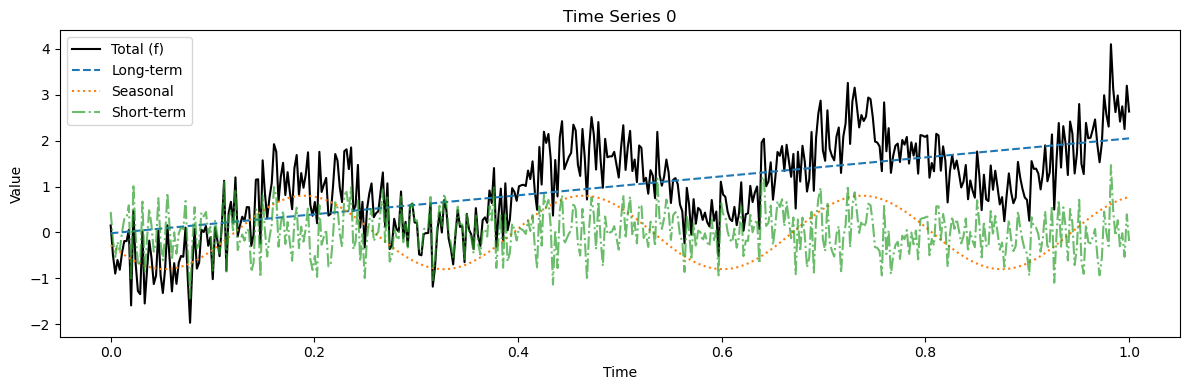

torch.Size([5, 450])
torch.Size([5, 450])
torch.Size([5, 450])


In [23]:
dataset = MultiTimeSeriesDataset(num_series=5)

check_dataset_format(dataset.x, dataset.y, "dataset.x")

dataset.plot_dataset(1)

loader = DataLoader(dataset, batch_size=5, shuffle=False)

x_batch, y_batch, f_long_batch, f_seasonal_batch, f_short_batch = next(iter(loader))
print(x_batch.shape)        # [5, T]
print(y_batch.shape)        # [5, T]
print(f_long_batch.shape)   # [5, T]

In [24]:
class NamedKernelBuilder:
    """
    A builder for composing named GPyTorch kernels into additive and product structures.

    Enables external control of priors and flexible kernel composition.
    """

    def __init__(self):
        self.components: Dict[str, Kernel] = {}

    def add(self, name: str, kernel: Kernel) -> "NamedKernelBuilder":
        """Add a named kernel component."""
        self.components[name] = kernel
        return self

    def add_product(self, name: str, k1: Kernel, k2: Kernel) -> "NamedKernelBuilder":
        """Add a kernel that is the product of two sub-kernels."""
        self.components[name] = k1 * k2
        return self

    def build(self) -> Optional[Kernel]:
        """Return the sum of all named components as a single composite kernel."""
        composite = None
        for k in self.components.values():
            composite = k if composite is None else composite + k
        return composite

    def get_named_components(self) -> Dict[str, Kernel]:
        """Access the individual named kernel components."""
        return self.components

    # --------------------------
    # Kernel constructors with priors
    # --------------------------

    @staticmethod
    def make_rbf_kernel(priors: Optional[Dict[str, Any]] = None) -> Kernel:
        k = RBFKernel()
        if priors and "lengthscale" in priors:
            low, high = priors["lengthscale"]
            k.register_prior("rbf_lengthscale_prior", SmoothedBoxPrior(low, high), "lengthscale")
        return k

    @staticmethod
    def make_matern_kernel(priors: Optional[Dict[str, Any]] = None) -> Kernel:
        k = MaternKernel(nu=1.5)
        if priors and "lengthscale" in priors:
            low, high = priors["lengthscale"]
            k.register_prior("matern_lengthscale_prior", SmoothedBoxPrior(low, high), "lengthscale")
        return k

    @staticmethod
    def make_periodic_kernel(priors: Optional[Dict[str, Any]] = None) -> Kernel:
        k = PeriodicKernel()
        if priors and "period_length" in priors:
            low, high = priors["period_length"]
            k.register_prior("period_length_prior", SmoothedBoxPrior(low, high), "period_length")
        return k

    # --------------------------
    # Config-driven factory
    # --------------------------

    @staticmethod
    def build_from_config(config: Dict[str, Any]) -> "NamedKernelBuilder":
        """
        Build a composite kernel based on a structured config.

        Expected config structure:
            {
                "long_term": {
                    "enabled": True,
                    "prior": {"lengthscale": [0.2, 1.5]}
                },
                "short_term": {
                    "enabled": True,
                    "prior": {"lengthscale": [0.01, 0.3]}
                },
                "seasonality": {
                    "enabled": True,
                    "prior": {
                        "period_length": [0.2, 0.3],
                        "lengthscale": [0.1, 1.0]  # for RBF inside periodic
                    }
                },
                "noise": {
                    "enabled": False
                }
            }
        """
        builder = NamedKernelBuilder()

        # Long-term trend kernel
        if config.get("long_term", {}).get("enabled", False):
            priors = config["long_term"].get("prior", None)
            builder.add("long_term", NamedKernelBuilder.make_rbf_kernel(priors))

        # Short-term kernel
        if config.get("short_term", {}).get("enabled", False):
            priors = config["short_term"].get("prior", None)
            builder.add("short_term", NamedKernelBuilder.make_matern_kernel(priors))

        # Seasonality = Periodic * RBF
        if config.get("seasonality", {}).get("enabled", False):
            priors = config["seasonality"].get("prior", {})
            periodic = NamedKernelBuilder.make_periodic_kernel(priors)
            rbf = NamedKernelBuilder.make_rbf_kernel(priors)
            builder.add_product("seasonality", periodic, rbf)

        # Noise kernel (short-lengthscale RBF)
        if config.get("noise", {}).get("enabled", False):
            priors = config["noise"].get("prior", None)
            builder.add("noise", NamedKernelBuilder.make_rbf_kernel(priors))

        return builder


##💡 Optional Enhancements (Not necessary, just future ideas)
#
#| Feature | What it adds |
#|--------|--------------|
#| `wrap_in_scale=True` | Automatically wrap components in `ScaleKernel`, optionally with `outputscale` priors |
#| `builder.describe()` | Print summary of included components and their priors |
#| `from_yaml(path)` | One-liner config from file (easy CLI/experiment pipeline) |
#| `freeze_component(name)` | Lock a kernel’s hyperparams for ablation |
#| `builder.get_kernel_by_name("seasonality")` | Access for fine-tuning after training |

In [25]:
class BatchedGPModel(ApproximateGP):
    """
    Variational Gaussian Process model for batched (multi-task) time series.

    This model supports independent GPs per task, sharing a common kernel structure
    but with separate variational distributions and inducing points.

    Args:
        inducing_points (Tensor): A tensor of shape [num_tasks, num_inducing, input_dim].
        kernel_builder (NamedKernelBuilder): Kernel builder with additive/product structure.

    Attributes:
        named_kernels (dict): Dictionary of named components used in kernel composition.
        covar_module (Kernel): Final composite kernel wrapped with a ScaleKernel.
        mean_module (Mean): Zero mean module shared across tasks.
    """

    def __init__(self, inducing_points: torch.Tensor, kernel_builder: "NamedKernelBuilder") -> None:
        num_tasks, num_inducing, _ = inducing_points.shape
        self.num_tasks = num_tasks

        # Task-wise variational distributions
        variational_distribution = CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=torch.Size([num_tasks])
        )

        # Learnable inducing point strategy per task
        variational_strategy = VariationalStrategy(
            self,
            inducing_points=inducing_points,
            variational_distribution=variational_distribution,
            learn_inducing_locations=True
        )

        super().__init__(variational_strategy)

        # Shared zero mean function across all tasks
        self.mean_module = gpytorch.means.ZeroMean()

        # Store individual named components for interpretability
        self.named_kernels: dict[str, Kernel] = kernel_builder.get_named_components()

        # Build full kernel and wrap it with a scaling layer
        composite_kernel = kernel_builder.build()
        self.covar_module = gpytorch.kernels.ScaleKernel(composite_kernel)

    def forward(self, x: torch.Tensor) -> gpytorch.distributions.MultivariateNormal:
        """
        Compute the multivariate normal distribution for input x.

        Args:
            x (Tensor): Input of shape [num_tasks, T, input_dim].

        Returns:
            MultivariateNormal: GP predictive distribution.
        """
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)



## 💡 Optional Extras (only if needed later)
#
#| Idea | Benefit |
#|------|---------|
#| Accept `mean_type="zero"` or `"constant"` | More flexible mean modeling |
#| Parameterize `ScaleKernel(outputscale_prior=...)` | Regularize total amplitude |
#| Support `task-specific kernels` (multioutput GPs) | Future: more expressiveness |
#| Freeze specific components (e.g., `noise`) | For ablation or regularization |
#| Register `named_kernels` inside `covar_module` | Easier inspection if you nest deeply |

In [26]:
def select_signal_aware_inducing_points(
    x: torch.Tensor,
    y: torch.Tensor,
    num_inducing: int = 64,
    threshold: float = 0.05,
    bias_ratio: float = 0.5
) -> torch.Tensor:
    """
    Select inducing points for Gaussian Process training by emphasizing
    regions with strong signal (i.e., abs(y) > threshold).

    Args:
        x (Tensor): Time input of shape [T, 1].
        y (Tensor): Target values of shape [T] or [T, 1].
        num_inducing (int): Total number of inducing points to select.
        threshold (float): Minimum absolute y value to be considered "signal".
        bias_ratio (float): Fraction of inducing points to sample from signal regions.

    Returns:
        Tensor: Inducing points of shape [num_inducing, 1], sorted along time.
    
    Notes:
        - Falls back to random sampling if there aren't enough signal/background points.
        - If bias_ratio = 0.0, selects randomly; if 1.0, selects entirely from signal.
    """

    # Ensure y is [T]
    if y.ndim == 2:
        y = y.squeeze(-1)

    # Identify signal regions
    signal_mask = y.abs() > threshold
    signal_x = x[signal_mask]
    background_x = x[~signal_mask]

    # Determine how many points to draw from each
    num_signal = int(bias_ratio * num_inducing)
    num_background = num_inducing - num_signal

    # Sample from signal region
    if len(signal_x) >= num_signal:
        inducing_signal = signal_x[torch.randperm(len(signal_x))[:num_signal]]
    else:
        # Pad with random x values if not enough signal points
        extra = x[torch.randperm(x.shape[0])[:num_signal - len(signal_x)]]
        inducing_signal = torch.cat([signal_x, extra], dim=0)

    # Sample from background region
    if len(background_x) >= num_background:
        inducing_background = background_x[torch.randperm(len(background_x))[:num_background]]
    else:
        # Pad with random x values if not enough background points
        extra = x[torch.randperm(x.shape[0])[:num_background - len(background_x)]]
        inducing_background = torch.cat([background_x, extra], dim=0)

    # Combine and sort
    inducing_points = torch.cat([inducing_signal, inducing_background], dim=0)
    inducing_points = inducing_points[:num_inducing].sort(dim=0).values

    return inducing_points.unsqueeze(-1)  # Shape: [num_inducing, 1]


In [27]:
config = {
    "long_term": {
        "enabled": True,
        "prior": {"lengthscale": [0.2, 1.5]}
    },
    "short_term": {
        "enabled": True,
        "prior": {"lengthscale": [0.01, 0.3]}
    },
    "seasonality": {
        "enabled": True,
        "prior": {
            "period_length": [0.2, 0.3],
            "lengthscale": [0.05, 1.0]  # for the RBF part
        }
    },
    "noise": {
        "enabled": False
    }
}


In [28]:
def get_batch_from_loader(loader: DataLoader) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Retrieve the first batch of (x, y) from a DataLoader.

    Args:
        loader (DataLoader): A PyTorch DataLoader yielding batches of tensors.

    Returns:
        Tuple[Tensor, Tensor]: A tuple of (train_xs, train_ys).

    Notes:
        - Assumes that each batch contains at least two elements (x, y).
        - Ignores any additional components beyond the first two.
    """
    try:
        batch = next(iter(loader))
        train_xs, train_ys, *_ = batch  # *_ to ignore optional extra components
        return train_xs, train_ys
    except StopIteration:
        raise ValueError("The provided DataLoader is empty.")


In [29]:
def build_signal_aware_inducing_points(
    train_xs: torch.Tensor,
    train_ys: torch.Tensor,
    num_inducing: int = 64,
    threshold: float = 0.05,
    bias_ratio: float = 0.7
) -> torch.Tensor:
    """
    Construct batched inducing points for multi-task Gaussian Processes,
    using signal-aware sampling per task.

    Args:
        train_xs (Tensor): Input time points, shape [num_tasks, T].
        train_ys (Tensor): Target values, shape [num_tasks, T].
        num_inducing (int): Number of inducing points per task.
        threshold (float): Signal detection threshold on abs(y).
        bias_ratio (float): Fraction of inducing points biased toward signal.

    Returns:
        Tensor: Inducing points of shape [num_tasks, num_inducing, 1].
    
    Notes:
        - Assumes 1D time input (shape [T]).
        - Uses `select_signal_aware_inducing_points()` for per-task selection.
    """
    inducing_points_list = []
    num_tasks = train_xs.shape[0]

    for i in range(num_tasks):
        inducing_i = select_signal_aware_inducing_points(
            x=train_xs[i].unsqueeze(-1),  # shape [T, 1]
            y=train_ys[i],                # shape [T]
            num_inducing=num_inducing,
            threshold=threshold,
            bias_ratio=bias_ratio
        )
        inducing_i = inducing_i.squeeze(-1)
        inducing_points_list.append(inducing_i)  # shape [num_inducing, 1]

    # Stack into shape: [num_tasks, num_inducing, 1]
    return torch.stack(inducing_points_list)


In [30]:
def initialize_model(
    train_xs: torch.Tensor,
    train_ys: torch.Tensor,
    config: Dict[str, bool]
) -> Tuple[gpytorch.models.ExactGP, gpytorch.likelihoods.GaussianLikelihood]:
    """
    Initialize a batched variational GP model and its likelihood.

    Args:
        train_xs (Tensor): Batched input time points, shape [num_tasks, T].
        train_ys (Tensor): Batched target values, shape [num_tasks, T].
        config (dict): Kernel component configuration dictionary, e.g.:
                       {"long_term": True, "short_term": True, "seasonality": False, "noise": True}

    Returns:
        Tuple:
            - model (BatchedGPModel): GP model with specified kernel structure.
            - likelihood (GaussianLikelihood): Task-wise Gaussian likelihood.
    """

    # Build inducing points per task
    inducing_points = build_signal_aware_inducing_points(train_xs, train_ys)

    # Create a kernel builder from config
    kernel_builder = NamedKernelBuilder.build_from_config(config)

    # Instantiate the GP model
    model = BatchedGPModel(
        inducing_points=inducing_points,
        kernel_builder=kernel_builder
    )

    # Create a batched likelihood (one Gaussian noise scale per task)
    likelihood = gpytorch.likelihoods.GaussianLikelihood(
        batch_shape=torch.Size([train_xs.size(0)])
    )

    return model, likelihood


In [31]:
def setup_training(
    model: gpytorch.models.ApproximateGP,
    likelihood: gpytorch.likelihoods.Likelihood,
    train_ys: torch.Tensor,
    lr: float = 0.01
) -> Tuple[torch.optim.Optimizer, gpytorch.mlls.VariationalELBO]:
    """
    Set up the optimizer and loss function (ELBO) for variational GP training.

    Args:
        model (ApproximateGP): The batched GP model to train.
        likelihood (Likelihood): Associated likelihood module.
        train_ys (Tensor): Training targets of shape [num_tasks, T], used to estimate dataset size.
        lr (float): Learning rate for optimizer.

    Returns:
        Tuple:
            - optimizer: Adam optimizer with model and likelihood parameters.
            - elbo: VariationalELBO loss function instance.
    """
    # Combine model and likelihood parameters
    optimizer = torch.optim.Adam(
        [
            {'params': model.parameters()},
            {'params': likelihood.parameters()}
        ],
        lr=lr
    )

    # Variational ELBO objective
    elbo = gpytorch.mlls.VariationalELBO(
        likelihood=likelihood,
        model=model,
        num_data=train_ys.size(1)  # total time points per task
    )

    return optimizer, elbo


In [32]:
def train_model(
    model: gpytorch.models.ApproximateGP,
    likelihood: gpytorch.likelihoods.Likelihood,
    optimizer: torch.optim.Optimizer,
    elbo: gpytorch.mlls.VariationalELBO,
    train_xs: torch.Tensor,
    train_ys: torch.Tensor,
    num_epochs: int = 600,
    log_interval: int = 10,
    log_fn: Optional[callable] = None,  # optional logging hook,
    gradient_clipping: bool = False
) -> None:
    """
    Train a variational GP model with ELBO loss over multiple epochs.

    Args:
        model (ApproximateGP): The GP model.
        likelihood (Likelihood): Associated likelihood.
        optimizer (Optimizer): Optimizer instance (e.g., Adam).
        elbo (VariationalELBO): Loss function.
        train_xs (Tensor): Input data [num_tasks, T].
        train_ys (Tensor): Target data [num_tasks, T].
        num_epochs (int): Number of training epochs.
        log_interval (int): Print/log frequency.
        log_fn (callable, optional): Optional logging hook called with (epoch, loss).

    Returns:
        None
    """
    model.train()
    likelihood.train()

    for epoch in range(num_epochs):
        optimizer.zero_grad()

        # GPyTorch expects input shape [num_tasks, T, 1]
        x_batch = train_xs.unsqueeze(-1)  # add input_dim=1
        y_batch = train_ys

        output = model(x_batch)

        # Negative ELBO (sum over batch)
        loss = -elbo(output, y_batch).sum()

        loss.backward()
        if gradient_clipping:
            # Gradient clipping: stabilize training by preventing exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        if epoch % log_interval == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f}")
            if log_fn:
                log_fn(epoch, loss.item())



In [33]:
# 1. Get data
train_xs, train_ys = get_batch_from_loader(loader)

# 2. Initialize model & likelihood
model, likelihood = initialize_model(train_xs, train_ys, config)

# 3. Setup optimizer and ELBO
optimizer, elbo = setup_training(model, likelihood, train_ys)

# 4. Train
train_model(model, likelihood, optimizer, elbo, train_xs, train_ys, num_epochs=600)


Epoch 000 | Loss: 37.6438
Epoch 010 | Loss: 23.7633
Epoch 020 | Loss: 17.7264
Epoch 030 | Loss: 14.3449
Epoch 040 | Loss: 12.1305
Epoch 050 | Loss: 10.5461
Epoch 060 | Loss: 9.3860
Epoch 070 | Loss: 8.5441
Epoch 080 | Loss: 7.9231
Epoch 090 | Loss: 7.4656
Epoch 100 | Loss: 7.0922
Epoch 110 | Loss: 6.7998
Epoch 120 | Loss: 6.5264
Epoch 130 | Loss: 6.3510
Epoch 140 | Loss: 6.0689
Epoch 150 | Loss: 5.8631
Epoch 160 | Loss: 5.6364
Epoch 170 | Loss: 5.4514
Epoch 180 | Loss: 5.3032
Epoch 190 | Loss: 5.2688
Epoch 200 | Loss: 5.2192
Epoch 210 | Loss: 5.0599
Epoch 220 | Loss: 4.9489
Epoch 230 | Loss: 4.8409
Epoch 240 | Loss: 4.7771
Epoch 250 | Loss: 4.7049
Epoch 260 | Loss: 4.5948
Epoch 270 | Loss: 4.5587
Epoch 280 | Loss: 4.6445
Epoch 290 | Loss: 4.7672
Epoch 300 | Loss: 4.6257
Epoch 310 | Loss: 4.4804
Epoch 320 | Loss: 4.3723
Epoch 330 | Loss: 4.2890
Epoch 340 | Loss: 4.2372
Epoch 350 | Loss: 4.1946
Epoch 360 | Loss: 4.2859
Epoch 370 | Loss: 4.3871
Epoch 380 | Loss: 4.2849
Epoch 390 | Loss: 4

In [34]:
def predict(model, likelihood, x_test: torch.Tensor) -> Dict[str, torch.Tensor]:
    """
    Runs batched GP prediction with noise and confidence intervals.

    Args:
        model: Trained GPyTorch model
        likelihood: Likelihood module (e.g. Gaussian)
        x_test: Input tensor [num_tasks, T, D]

    Returns:
        Dict with mean, lower, upper (each [num_tasks, T])
    """
    model.eval()
    likelihood.eval()

    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        preds = likelihood(model(x_test))
        mean = preds.mean
        lower, upper = preds.confidence_region()

    return {"mean": mean, "lower": lower, "upper": upper}


In [35]:
class GPForecaster:
    def __init__(self, model, likelihood):
        self.model = model
        self.likelihood = likelihood

    def predict(self, x_test: torch.Tensor, batch_size: Optional[int] = None) -> Dict[str, torch.Tensor]:
        """
        Predicts for all tasks in batch or in mini-batches if specified.

        Args:
            x_test: [N, T, D] tensor of test inputs
            batch_size: If specified, split across task dimension

        Returns:
            Dictionary with 'mean', 'lower', 'upper' predictions [N, T]
        """
        self.model.eval()
        self.likelihood.eval()

        N, T, D = x_test.shape
        mean_all, lower_all, upper_all = [], [], []

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            for start in range(0, N, batch_size or N):
                end = min(start + (batch_size or N), N)
                x_batch = x_test[start:end]
                preds = self.likelihood(self.model(x_batch))
                mean_all.append(preds.mean)
                l, u = preds.confidence_region()
                lower_all.append(l)
                upper_all.append(u)

        return {
            "mean": torch.cat(mean_all, dim=0),
            "lower": torch.cat(lower_all, dim=0),
            "upper": torch.cat(upper_all, dim=0)
        }


In [37]:
forecaster = GPForecaster(model, likelihood)

num_tasks = train_ys.size(0)  # or train_xs.size(0)

x_test = torch.linspace(0, 1, 450).unsqueeze(-1).unsqueeze(0).repeat(num_tasks, 1, 1)  # [N, T, 1]

results = forecaster.predict(x_test)

mean = results["mean"]       # [N, T]
lower = results["lower"]     # [N, T]
upper = results["upper"]     # [N, T]


In [40]:
def plot_gp_prediction(
    task_id: int,
    train_xs: torch.Tensor,
    train_ys: torch.Tensor,
    x_test: torch.Tensor,
    pred_dict: dict,
    title: str = None
):
    """
    Plots a single GP prediction with 95% CI.

    Args:
        task_id (int): Which task to plot
        train_xs, train_ys (Tensor): Training data, shapes [N, T]
        x_test (Tensor): Input used for prediction, shape [N, T, D]
        pred_dict (dict): Must contain 'mean', 'lower', 'upper' [N, T]
        title (str): Optional plot title
    """
    x_train = train_xs[task_id].detach().cpu()
    y_train = train_ys[task_id].detach().cpu()
    x_pred = x_test[task_id].squeeze(-1).detach().cpu()
    y_mean = pred_dict["mean"][task_id].detach().cpu()
    y_lower = pred_dict["lower"][task_id].detach().cpu()
    y_upper = pred_dict["upper"][task_id].detach().cpu()

    plt.figure(figsize=(10, 4))
    plt.plot(x_train, y_train, 'k.', label='Observed', alpha=0.4)
    plt.plot(x_pred, y_mean, 'b', label='Predicted f(x)')
    plt.fill_between(x_pred, y_lower, y_upper, color='b', alpha=0.3, label='95% CI')

    plt.title(title or f"Task {task_id}: GP Prediction")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


In [41]:
def plot_gp_components(
    task_id: int,
    model,
    x_test: torch.Tensor,
    train_xs: torch.Tensor,
    train_ys: torch.Tensor,
    label_observed: str = "Observed",
    title: str = None
):
    """
    Plots component-wise predictions by replacing covar_module with each named kernel.

    Args:
        task_id: Task index to visualize
        model: Trained GPyTorch model with .named_kernels
        x_test: Test input [N, T, D]
        train_xs, train_ys: Training data [N, T]
        label_observed: Optional override for observed label
        title: Plot title
    """
    x_obs = train_xs[task_id].detach().cpu()
    y_obs = train_ys[task_id].detach().cpu()
    x_plot = x_test[task_id].squeeze(-1).detach().cpu().numpy()

    model.eval()
    original_kernel = model.covar_module

    plt.figure(figsize=(12, 5))
    plt.plot(x_obs, y_obs, 'k.', alpha=0.3, label=label_observed)

    # Full model prediction
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        full_preds = model(x_test)
        full_mean = full_preds.mean[task_id].detach().cpu().numpy()
        plt.plot(x_plot, full_mean, 'b-', label='Full f(x)', linewidth=2)

    # Component predictions
    for name, kernel in model.named_kernels.items():
        model.covar_module = kernel
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            preds = model(x_test)
            comp_mean = preds.mean[task_id].detach().cpu().numpy()
            plt.plot(x_plot, comp_mean, linestyle='--', label=name)

    model.covar_module = original_kernel  # restore

    plt.title(title or f"Task {task_id}: Component Contributions")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


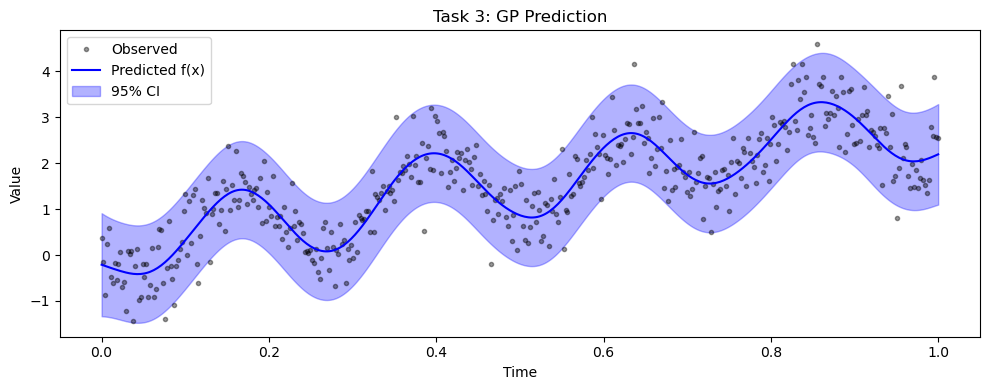

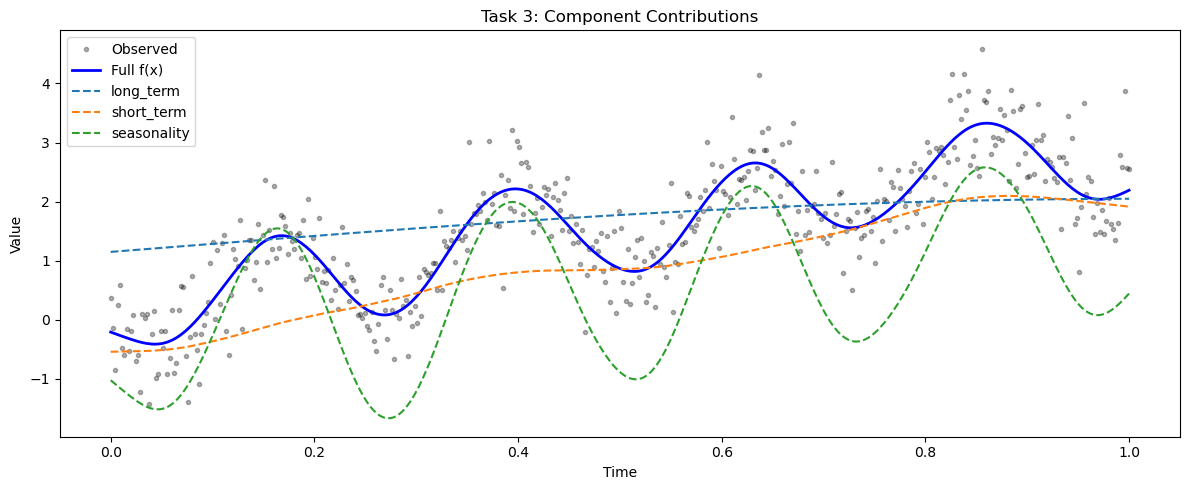

In [42]:
# Run model prediction
results = forecaster.predict(x_test)

# Plot full prediction
plot_gp_prediction(task_id=3, train_xs=train_xs, train_ys=train_ys, x_test=x_test, pred_dict=results)

# Plot kernel contributions
plot_gp_components(task_id=3, model=model, x_test=x_test, train_xs=train_xs, train_ys=train_ys)
